In [1]:
import numpy as np
import awkward as ak
import fastjet
import uproot4 as ur
import matplotlib.colors as mcolors
import mplhep as hep
import matplotlib.pyplot as plt
import math
import matplotlib as colors
import matplotlib as abc
from scipy.optimize import curve_fit
import pandas as pd
from iminuit import Minuit
from iminuit.cost import LeastSquares

hep.style.use(hep.style.CMS)
hep.style.use("CMS")
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [2]:
def eta(r, z):
    theta = abs(np.arctan(r / z))
    result = np.where(z < 0, np.log(np.tan(theta / 2)), -1 * np.log(np.tan(theta / 2)))
    return result

def phi(x,y):
    return np.arctan2(y, x)

def momentum_xyz(px, py, pz):
    norm = np.sqrt(px**2 + py**2 + pz**2)
    x = px / norm
    y = py / norm
    z = pz / norm
    return x, y, z

def jet_dict(px, py, pz, e, minE):
    momenta = ak.zip(
    {
        "px": ak.Array(px),
        "py": ak.Array(py),
        "pz": ak.Array(pz),
        "E": ak.Array(e),
    }
    )
    lorentz = ak.Array(momenta, with_name="Momentum4D", behavior=ak.behavior)
    
    # Define the jet definition
    jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 1.0)

    # Cluster the particles into jets
    cluster = fastjet.ClusterSequence(lorentz, jetdef)
    inc_jets = cluster.inclusive_jets()
    x, y, z = momentum_xyz(inc_jets.px, inc_jets.py, inc_jets.pz)
    jeta = eta(np.sqrt(x**2 + y**2), z)
    
    etaMin = 2.4
    
    cut_secondary = (inc_jets.E >= 10) & (jeta >= etaMin)
    
    data_dict = {
        "energy": inc_jets.E[cut_secondary],
        "eta": jeta[cut_secondary],
        "phi": phi(x[cut_secondary], y[cut_secondary])
    }
    return data_dict

In [3]:
input_file = 'SimpleTree_mudst_pythia.root'
events = ur.open("%s:data"%(input_file))
arrays = events.arrays()

posx = arrays['Cal_hit_posx']
posy = arrays['Cal_hit_posy']
posz = arrays['Cal_hit_posz']
energy = arrays['Cal_hit_energy']
detid = arrays['Cal_detid']

adcsum = arrays['Cal_adcsum']
detid = arrays['Cal_detid']

cut_primary = (arrays['Cal_hit_energy']>0.1) & ((arrays['Cal_detid']==0) ^(arrays['Cal_detid']==1) ^ (arrays['Cal_detid']==2) ^ (arrays['Cal_detid']==3))

xcut = posx[cut_primary]
ycut = posy[cut_primary]
zcut = posz[cut_primary]
ecut = energy[cut_primary]

norms = np.sqrt(xcut**2 + ycut**2 + zcut**2)
px = (xcut / norms) * ecut
py = (ycut / norms) * ecut
pz = (zcut / norms) * ecut

reco_dict = jet_dict(px, py, pz, ecut, 0)

In [4]:
input_file = 'pythia8.starsim.root'
events = ur.open("%s:genevents/primaryEvent/mParticles"%(input_file))
arrays = events.arrays()

cut_primary = (arrays['mParticles.mStatus'] == 1)

energy = arrays['mParticles.mEnergy'][cut_primary]
status = arrays['mParticles.mStatus'][cut_primary]
Px = arrays['mParticles.mPx'][cut_primary]
Py = arrays['mParticles.mPy'][cut_primary]
Pz = arrays['mParticles.mPz'][cut_primary]

gen_dict = jet_dict(Px, Py, Pz, energy, 10)

In [5]:
PairedJetE = []
PairedGJetE = []
PairedDR = []

for evt in range(len(reco_dict["energy"])):
    if evt%1000 == 0:
        print(evt)
    EvtJetE = []
    EvtGJetE = []
    EvtDR = []
    for jet in range(len(reco_dict["energy"][evt])):
        minR = -1
        gindex = -1
        deltaR = -1
        for gjet in range(len(gen_dict["energy"][evt])):
            deltaR = np.sqrt(np.square(gen_dict["eta"][evt][gjet] - reco_dict["eta"][evt][jet]) + np.square((gen_dict["phi"][evt][gjet] - reco_dict["phi"][evt][jet])))
            if ((minR > deltaR) or (minR == -1)) and (deltaR <= 1.0):
                minR = deltaR
                gindex = gjet
        if gindex != -1:
            EvtJetE.append(reco_dict["energy"][evt][jet])
            EvtGJetE.append(gen_dict["energy"][evt][gindex])
            EvtDR.append(deltaR)
    if(len(EvtJetE) != 0):
        PairedJetE.append(EvtJetE)
        PairedGJetE.append(EvtGJetE)
        PairedDR.append(EvtDR)

PairedGJetE = ak.flatten(PairedGJetE)
PairedJetE = ak.flatten(PairedJetE)
EDiff = PairedGJetE - PairedJetE

JetR = PairedJetE/PairedGJetE

0


[5.0, 10.861266895718948, 17.28922070479688, 23.0580879167687, 25.30595729841016, 28.87263374793026, 64.34143124061218, 28.077100263353532, 253500.40555598075, 189130.3813606085]
[0.0, 2.553238589742475, 0.6147365077083732, 0.7352387541747009, 1.1883167534078367, 3.0545744798298355, 2.256226451952893, 8.929887891139042, 47539976.89919289, 17078.26179654528]


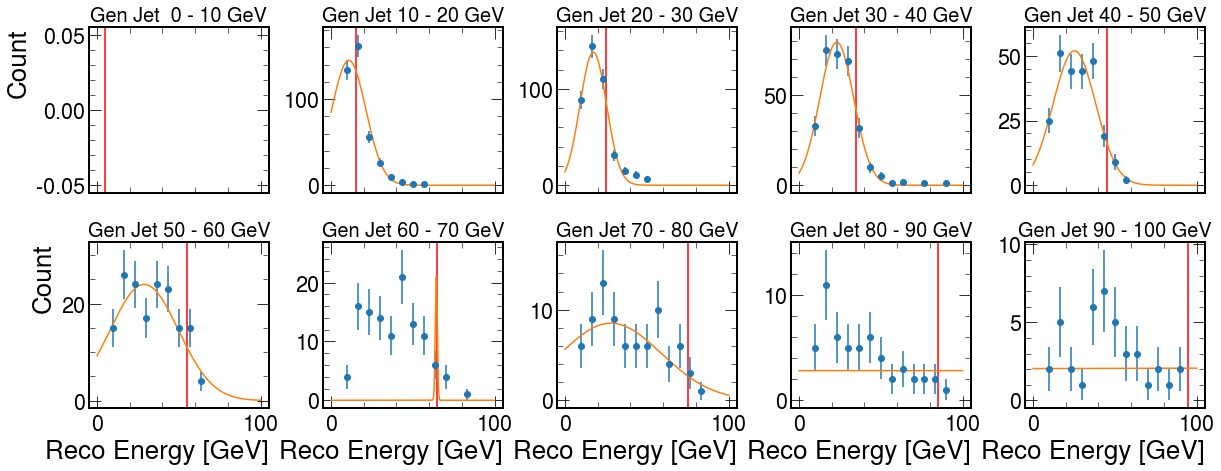

In [6]:
fig, axs=plt.subplots(2, 5, figsize=(20,7),sharex=True,gridspec_kw={'wspace': 0.3,'hspace': 0.3})
fig.subplots_adjust(wspace=0, hspace=0)

def gauss(x, A, mu, sigma):
    #A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


AvgEReco = []
AvgERecoErr = []

NumEReco = []
NumERecoErr = []

GenSlice = []

for i in range(10):
    x = i // 5  
    y = i % 5
    plt.sca(axs[x][y])
        
    genEBin = (PairedGJetE > i*10) & (PairedGJetE < (i+1)*10)
    
    hist, bin_edges = np.histogram(PairedJetE[genEBin],bins=15,range=(0,100))
    
    zerocut = (hist > 0)
    
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    plt.errorbar(np.array(bin_centres[zerocut]),np.array(hist[zerocut]),yerr=np.sqrt(hist[zerocut]),fmt="o")
    
    plt.axvline((i+0.5)*10,color='red')
    GenSlice.append((i+0.5)*10)
       
    least_squares = LeastSquares(list(bin_centres[zerocut]),list(hist[zerocut]),list(np.sqrt(hist[zerocut])),gauss)
    m = Minuit(least_squares, A=max(hist), mu = (i+0.5)*10, sigma = np.std(PairedJetE[genEBin]))
    m.migrad()
    m.hesse()
    hist_fit = gauss(np.linspace(0,100,5000), m.values[0],m.values[1],m.values[2])
    plt.plot(np.linspace(0,100,5000), hist_fit)
    
    NumEReco.append(np.mean(PairedJetE[genEBin]))
    NumERecoErr.append(np.std(PairedJetE[genEBin]))
    if not math.isnan(m.values[1]) :
        AvgEReco.append(m.values[1])
        AvgERecoErr.append(m.errors[1])
    else:
        AvgEReco.append(0)
        AvgERecoErr.append(0)

  
    if(y == 0):
        plt.ylabel("Count")
    if(x == 1):
        plt.xlabel("Reco Energy [GeV]")
    plt.title('Gen Jet %2.0f - %2.0f GeV'%(i*10, (i+1)*10),fontsize=20)
print(AvgEReco)
print(AvgERecoErr)

[1.0, 1.0162655338423174, 0.7446584333899812, 0.6325476319305339, 0.5872117564884094, 0.518898131340027, 0.4932549647235327, 0.570356672150065, 63.27373771302121, -5.748282695244998]
[0.0, 0.020112075565093517, 0.015106010903314005, 0.03009246129324037, 0.020503323340465698, 0.05139271164172965, 0.05967020961098127, 0.03524377152434415, 378.6017113479533, 5.233598311863936]


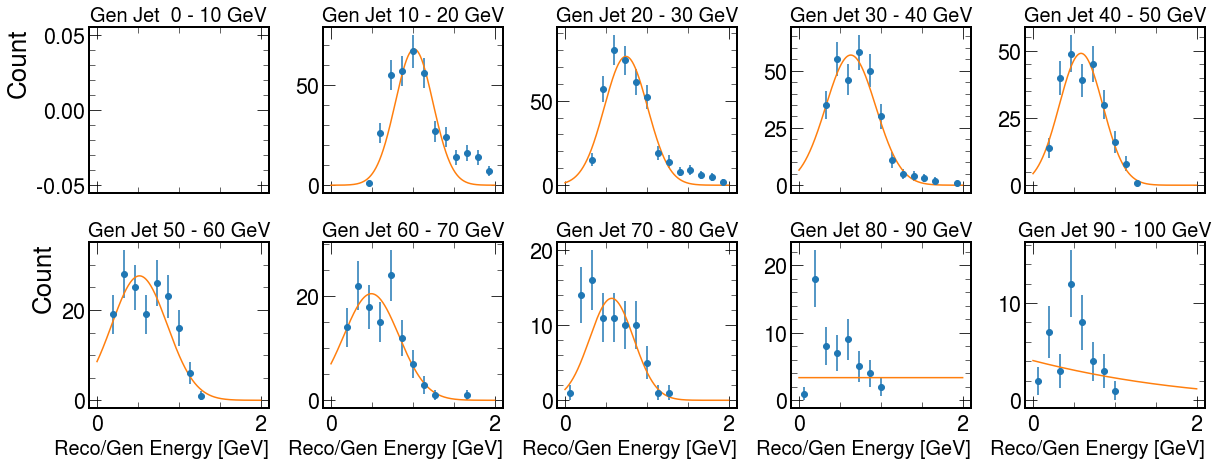

In [7]:
fig, axs=plt.subplots(2, 5, figsize=(20,7),sharex=True,gridspec_kw={'wspace': 0.3,'hspace': 0.3})
fig.subplots_adjust(wspace=0, hspace=0)

def gauss(x, A, mu, sigma):
 
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

AvgR = []
AvgRErr = []

NumR = []
NumRErr = []

for i in range(10):
    x = i // 5  
    y = i % 5
    plt.sca(axs[x][y])
        
    genEBin = (PairedGJetE > i*10) & (PairedGJetE < (i+1)*10)
    
    hist, bin_edges = np.histogram(PairedJetE[genEBin]/PairedGJetE[genEBin],bins=15,range=(0,2))
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
   
    
    zerocut = (hist > 0)
    
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    plt.errorbar(np.array(bin_centres[zerocut]),np.array(hist[zerocut]),yerr=np.sqrt(hist[zerocut]),fmt="o")
    
       
    least_squares = LeastSquares(list(bin_centres[zerocut]),list(hist[zerocut]),list(np.sqrt(hist[zerocut])),gauss)
    m = Minuit(least_squares, A=max(hist), mu = 1.0, sigma = np.std(PairedJetE[genEBin]/PairedGJetE[genEBin]))
    m.migrad()
    m.hesse()
    hist_fit = gauss(np.linspace(0,2,5000), m.values[0],m.values[1],m.values[2])
    plt.plot(np.linspace(0,2,5000), hist_fit)
    NumR.append(np.mean(PairedJetE[genEBin]/PairedGJetE[genEBin]))
    NumRErr.append(np.std(PairedJetE[genEBin]/PairedGJetE[genEBin]))
    if (not math.isnan(m.values[1])):
        AvgR.append(m.values[1])

        AvgRErr.append(m.errors[1])
    else:
        AvgR.append(0)
        AvgRErr.append(0)

  
    if(y == 0):
        plt.ylabel("Count")
    if(x == 1):
        plt.xlabel("Reco/Gen Energy [GeV]",fontsize=20)
    plt.title('Gen Jet %2.0f - %2.0f GeV'%(i*10, (i+1)*10),fontsize=20)
print(AvgR)
print(AvgRErr)

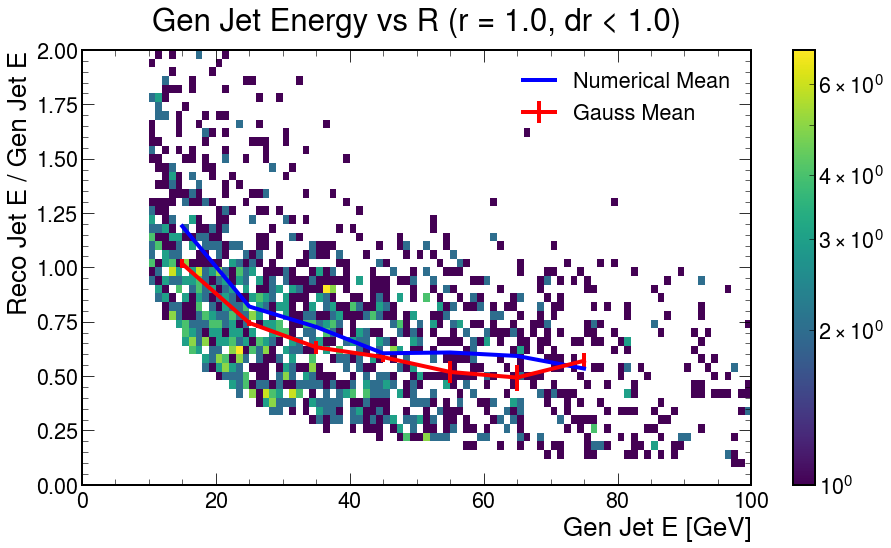

In [8]:
fig = plt.figure(figsize=(15,8))

plt.hist2d(np.array(PairedGJetE),np.array(JetR),bins=(100,50),range=([0,100],[0,2]),cmap='viridis',norm=abc.colors.LogNorm())
cbar = plt.colorbar()
plt.errorbar(GenSlice[1:-2], AvgR[1:-2], yerr=AvgRErr[1:-2],color='red',label="Gauss Mean",linewidth=4)
plt.plot(GenSlice[1:-2], NumR[1:-2], color='blue',label="Numerical Mean",linewidth=4)
plt.legend()
plt.xlabel('Gen Jet E [GeV]')
plt.ylabel('Reco Jet E / Gen Jet E')
plt.title("Gen Jet Energy vs R (r = 1.0, dr < 1.0)",pad = 20.0)
plt.show()

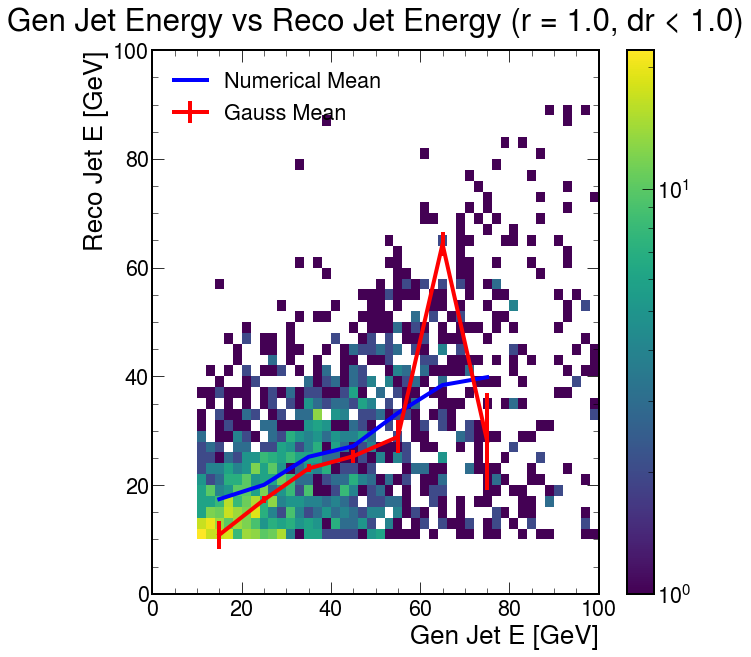

In [9]:
plt.hist2d(np.array(PairedGJetE),np.array(PairedJetE),bins=(50,50),range=([0,100],[0,100]),cmap='viridis',norm=abc.colors.LogNorm())
cbar = plt.colorbar()
plt.errorbar(GenSlice[1:-2], AvgEReco[1:-2], yerr=AvgERecoErr[1:-2],color='red',label="Gauss Mean",linewidth=4)
plt.plot(GenSlice[1:-2], NumEReco[1:-2], color='blue',label="Numerical Mean",linewidth=4)
plt.legend(loc='upper left')
plt.xlabel('Gen Jet E [GeV]')
plt.ylabel('Reco Jet E [GeV]')
plt.title("Gen Jet Energy vs Reco Jet Energy (r = 1.0, dr < 1.0)",pad = 20.0)
plt.show()

<ValueView A=3.876340401149199 B=-1.7172366546994708 C=0.2171469952826287>


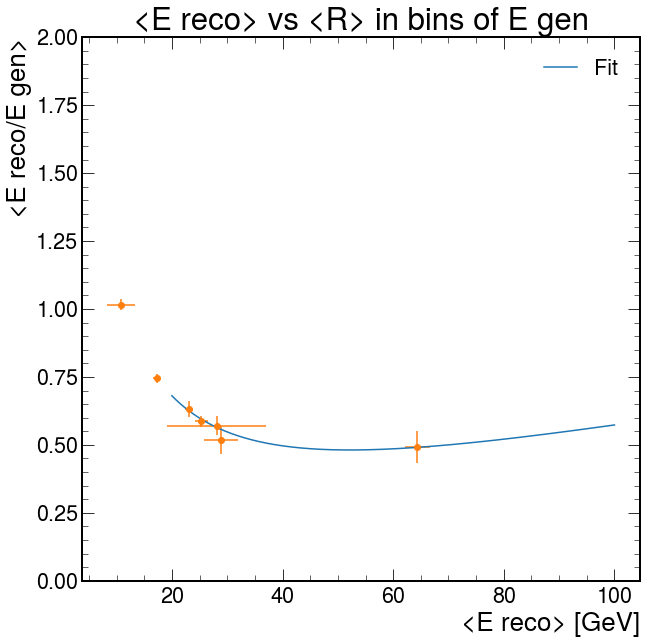

In [10]:

def correct(ereco, A, B, C):
    return A + (B*np.log(ereco)) + (C*np.square(np.log(ereco)))



least_squares = LeastSquares(AvgEReco[1:-2],AvgR[1:-2],AvgERecoErr[1:-2],correct)
m = Minuit(least_squares, A=0.5, B = -0.5, C = 0.5)
m.migrad()
m.hesse()

correct_fit = correct(np.linspace(20,100,5000), m.values[0], m.values[1], m.values[2])
plt.plot(np.linspace(20,100,5000), correct_fit, label="Fit")

plt.legend()


plt.errorbar(np.array(AvgEReco[1:-2]),np.array(AvgR[1:-2]),xerr=AvgERecoErr[1:-2],yerr=AvgRErr[1:-2],fmt="o")
plt.ylim(0,2)
plt.title("<E reco> vs <R> in bins of E gen")
plt.ylabel("<E reco/E gen>")
plt.xlabel("<E reco> [GeV]")
print(m.values)

In [11]:
correctedReco = PairedJetE / correct(PairedJetE, m.values[0], m.values[1], m.values[2])
JetRC = correctedReco/PairedGJetE

[5.0, -129.6015959251302, 4.241969183619095, 32.73073957818138, 29.3370672807442, -1134.362074966578, 496.88726349011006, -191.34349298789573, -32.56140075541829, 904.3886143615321]
[0.0, 145.40165959223867, 13.053280806567365, 3.2472191484967765, 10.288332112689975, 346.25895634153045, 1347.2662312955674, 1030.538484137965, 1.999997993534197, 1665.0377127058257]


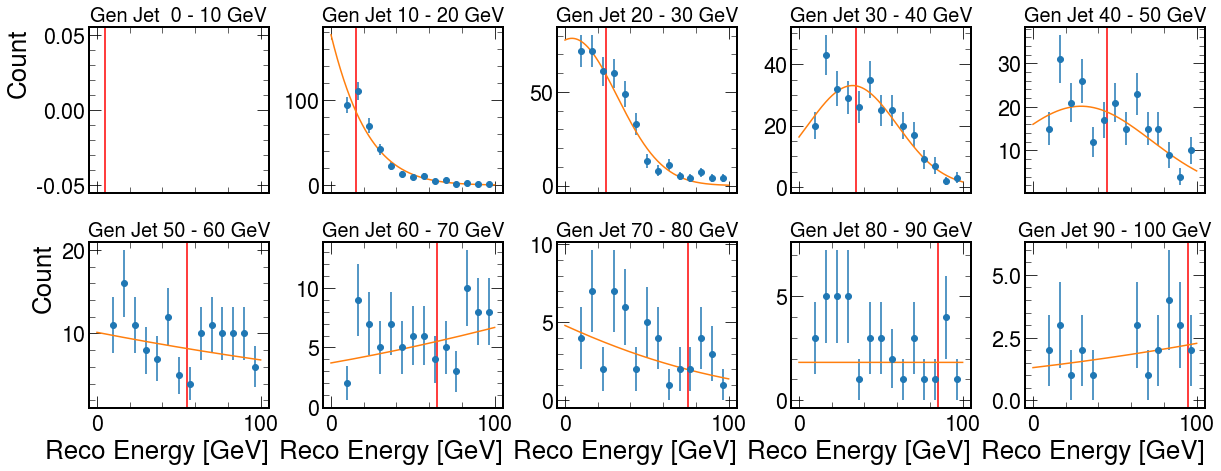

In [12]:
fig, axs=plt.subplots(2, 5, figsize=(20,7),sharex=True,gridspec_kw={'wspace': 0.3,'hspace': 0.3})
fig.subplots_adjust(wspace=0, hspace=0)

def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


CAvgEReco = []
CAvgERecoErr = []

CNumEReco = []
CNumERecoErr = []

GenSlice = []

for i in range(10):
    x = i // 5  
    y = i % 5
    plt.sca(axs[x][y])
        
    genEBin = (PairedGJetE > i*10) & (PairedGJetE < (i+1)*10)
    
    hist, bin_edges = np.histogram(correctedReco[genEBin],bins=15,range=(0,100))
    
    zerocut = (hist > 0)
    
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    plt.errorbar(np.array(bin_centres[zerocut]),np.array(hist[zerocut]),yerr=np.sqrt(hist[zerocut]),fmt="o")
    
    plt.axvline((i+0.5)*10,color='red')
    GenSlice.append((i+0.5)*10)
    
    least_squares = LeastSquares(list(bin_centres[zerocut]),list(hist[zerocut]),list(np.sqrt(hist[zerocut])),gauss)
    m = Minuit(least_squares, A=max(hist), mu = (i+0.5)*10, sigma = np.std(correctedReco[genEBin]))
    m.migrad()
    m.hesse()
    hist_fit = gauss(np.linspace(0,100,5000), m.values[0],m.values[1],m.values[2])
    plt.plot(np.linspace(0,100,5000), hist_fit)
    
    CNumEReco.append(np.mean(correctedReco[genEBin]))
    CNumERecoErr.append(np.std(correctedReco[genEBin]))
    if not math.isnan(m.values[1]):
        CAvgEReco.append(m.values[1])
        CAvgERecoErr.append(m.errors[1])
    else:
        CAvgEReco.append(0)
        CAvgERecoErr.append(0)

  
    if(y == 0):
        plt.ylabel("Count")
    if(x == 1):
        plt.xlabel("Reco Energy [GeV]")
    plt.title('Gen Jet %2.0f - %2.0f GeV'%(i*10, (i+1)*10),fontsize=20)
print(CAvgEReco)
print(CAvgERecoErr)

[1.0, 1.1178365416055822, 0.885917566514025, 1.1965375639942661, 0.7972408820406026, -18.58483729321399, -22.61907664887092, 1.400151155304192, -3.8300428662625072, 0.7996814852564379]
[0.0, 0.026324744589114792, 0.0597982616566984, 0.048840106556885185, 0.1569658200425533, 4.548775253682195, 16.200376453970648, 0.4552906732902924, 118.97319884975937, 0.2557799101456363]


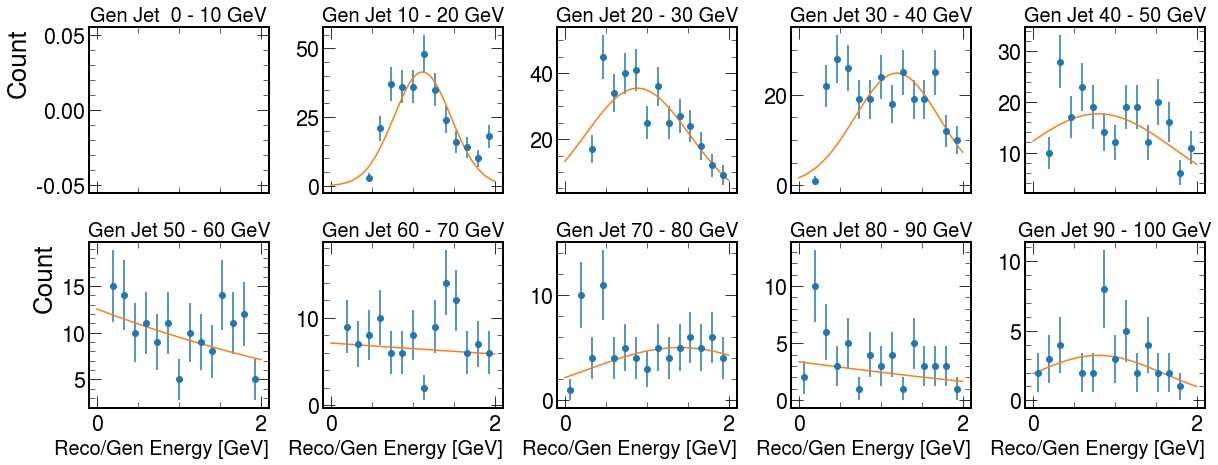

In [13]:
fig, axs=plt.subplots(2, 5, figsize=(20,7),sharex=True,gridspec_kw={'wspace': 0.3,'hspace': 0.3})
fig.subplots_adjust(wspace=0, hspace=0)

def gauss(x, A, mu, sigma):
 
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

CAvgR = []
CAvgRErr = []

CNumR = []
CNumRErr = []

for i in range(10):
    x = i // 5  
    y = i % 5
    plt.sca(axs[x][y])
        
    genEBin = (PairedGJetE > i*10) & (PairedGJetE < (i+1)*10)
    
    hist, bin_edges = np.histogram(JetRC[genEBin],bins=15,range=(0,2))
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
   
    
    zerocut = (hist > 0)
    
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    plt.errorbar(np.array(bin_centres[zerocut]),np.array(hist[zerocut]),yerr=np.sqrt(hist[zerocut]),fmt="o")
    
       
    least_squares = LeastSquares(list(bin_centres[zerocut]),list(hist[zerocut]),list(np.sqrt(hist[zerocut])),gauss)
    m = Minuit(least_squares, A=max(hist), mu = 1.0, sigma = np.std(JetRC[genEBin]))
    m.migrad()
    m.hesse()
    hist_fit = gauss(np.linspace(0,2,5000), m.values[0],m.values[1],m.values[2])
    plt.plot(np.linspace(0,2,5000), hist_fit)
    CNumR.append(np.mean(JetRC[genEBin]))
    CNumRErr.append(np.std(JetRC[genEBin]))
    if (not math.isnan(m.values[1])):
        CAvgR.append(m.values[1])

        CAvgRErr.append(m.errors[1])
    else:
        CAvgR.append(0)
        CAvgRErr.append(0)

  
    if(y == 0):
        plt.ylabel("Count")
    if(x == 1):
        plt.xlabel("Reco/Gen Energy [GeV]",fontsize=20)
    plt.title('Gen Jet %2.0f - %2.0f GeV'%(i*10, (i+1)*10),fontsize=20)
print(CAvgR)
print(CAvgRErr)

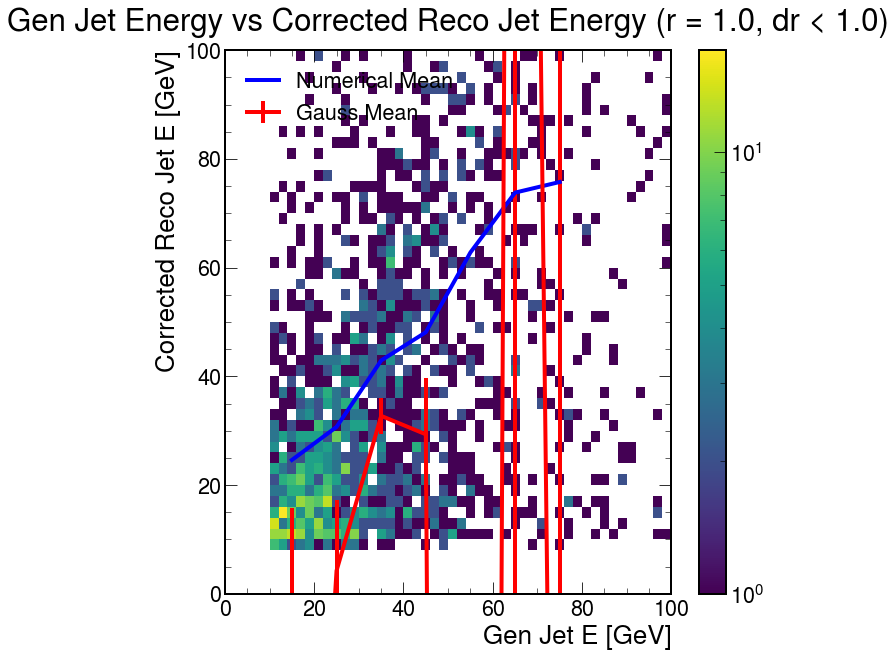

In [14]:
plt.hist2d(np.array(PairedGJetE),np.array(correctedReco),bins=(50,50),range=([0,100],[0,100]),cmap='viridis',norm=abc.colors.LogNorm())
cbar = plt.colorbar()
plt.errorbar(GenSlice[1:-2], CAvgEReco[1:-2], yerr=CAvgERecoErr[1:-2],color='red',label="Gauss Mean",linewidth=4)
plt.plot(GenSlice[1:-2], CNumEReco[1:-2], color='blue',label="Numerical Mean",linewidth=4)
plt.legend()

plt.xlabel('Gen Jet E [GeV]')
plt.ylabel('Corrected Reco Jet E [GeV]')
plt.title("Gen Jet Energy vs Corrected Reco Jet Energy (r = 1.0, dr < 1.0)",pad = 20.0)
plt.show()

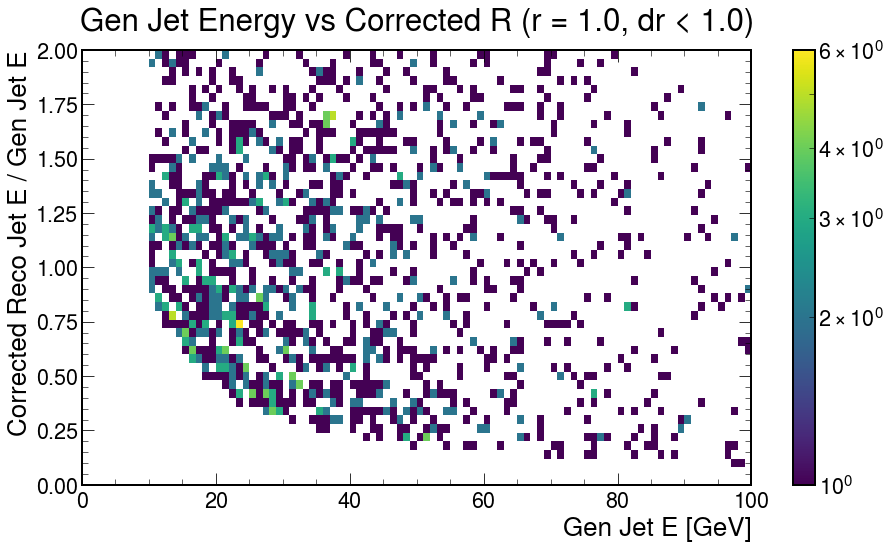

In [15]:
fig = plt.figure(figsize=(15,8))



plt.hist2d(np.array(PairedGJetE),np.array(JetRC),bins=(100,50),range=([0,100],[0,2]),cmap='viridis',norm=abc.colors.LogNorm())
cbar = plt.colorbar()

plt.xlabel('Gen Jet E [GeV]')
plt.ylabel('Corrected Reco Jet E / Gen Jet E')
plt.title("Gen Jet Energy vs Corrected R (r = 1.0, dr < 1.0)",pad = 20.0)
plt.show()